<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Copy_CNN_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [ ]:
!pip install tensorflow
!pip install keras

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import schedules, Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl # Estamos usando só o Nadam
from keras.models import Sequential
from keras.layers.embeddings import Embedding

In [61]:
def tokenize(tweets_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_list)
    return tokenizer.texts_to_sequences(tweets_list), tokenizer

In [62]:
def pad(text_tokenized, length=None):
    return pad_sequences(text_tokenized, maxlen=length, padding='post')

In [63]:
def preprocess(tweets_list, max_text_length):
    preprocess_tweets_list, tweets_list_tokenizer = tokenize(tweets_list)

    preprocess_tweets_list = pad(preprocess_tweets_list, length=max_text_length)

    return preprocess_tweets_list, tweets_list_tokenizer

In [64]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [65]:
# Plot de Gráficos

def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.show()
  
  
def plot_loss(history, miny=None):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('loss') 
  plt.xlabel('epoch')
  plt.show()

# Carrega base

In [100]:
# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv" #entrada

PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
# MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

# Execução modelo

In [101]:
tweets = pd.read_csv(PATH_BASE_2_CLASSIFICADA_BALANCEADA, index_col=0)
text_column = tweets['text']
text_column

0        retwet bahia fazer sendo governada pt sei baia...
1        k imagine atitude mental negativa f idiota fec...
2        general heleno é bolsonaro rosna late late lat...
3        alan ser cara pau achar havendo ruptura nesse ...
4        canalhascomunistas caçarão chapa presidencialn...
                               ...                        
10569               af hein amiga mandar outro número mail
10570    egoísmo é grande parte produto sociedade émile...
10571    abençoado novo linda querida obrigada carinho ...
10572                              leva gente amorzinhos d
10573                                   k k ata meia sonsa
Name: text, Length: 10574, dtype: object

In [102]:
# Pega a média de caracteres dos tweets de toda a base
max_text_length = int(text_column.apply(lambda x: len(str(x).split(' '))).max())
max_text_length

55

In [103]:
output_label = tweets['label']

input_data, text_tokenizer = preprocess(text_column, None)
    
text_vocab_size = len(text_tokenizer.word_index)
print("Vocabulary size:", text_vocab_size)

Vocabulary size: 19043


In [118]:
# parametros:
BATCH_SIZE = 64
EPOCHS = 50
VAL_AND_TST_SIZE = 0.2
LEARN_RATE = 0.0001
BETA_1 = 0.09
BETA_2 = 0.0999
EPSILON = 1e-07
EMBEDDING_DIMENSION = 300  
MAX_TEXT_SIZE = max_text_length 
VOCAB_SIZE = text_vocab_size



In [119]:
def optimize (learning_rate, beta_1, beta_2, epsilon):
  return Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, name="Nadam")

In [120]:
def create_cnn (vocab_size, embedding_dimen, max_text_size ):

  embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=MAX_TEXT_SIZE)

  int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Conv1D(100, 3, activation="relu")(embedded_sequences)
  x = layers.MaxPooling1D()(x)
  x = layers.Conv1D(100, 3, activation="relu")(x)
  x = layers.MaxPooling1D()(x)
  x = layers.Conv1D(100, 3, activation="relu")(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dense(100, activation="relu")(x)
  x = layers.Dropout(0.3)(x)
  preds = layers.Dense(2, activation="softmax")(x)
  model = keras.Model(int_sequences_input, preds)
  return model 
  

In [126]:
def train_model(input_data, output_label, embedding_dimen, batch_size, epochs, validation_and_test_size):
    
    X_train, X_test, y_train, y_test = train_test_split(input_data, output_label, test_size=validation_and_test_size)

    optimizer = optimize(LEARN_RATE, BETA_1, BETA_2, EPSILON)
    
    model = create_cnn(VOCAB_SIZE, EMBEDDING_DIMENSION, MAX_TEXT_SIZE)
    model.summary()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy'])                                                                                                
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), validation_split = validation_and_test_size, verbose=2, use_multiprocessing=True)
    scores = model.evaluate(X_test, y_test, verbose=1)
    
    return history

In [127]:
# plot dos gráficos
history = train_model(input_data, output_label, EMBEDDING_DIMENSION, BATCH_SIZE, EPOCHS, VAL_AND_TST_SIZE)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_26 (Embedding)    (None, None, 300)         5712900   
                                                                 
 conv1d_81 (Conv1D)          (None, None, 100)         90100     
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, None, 100)        0         
 g1D)                                                            
                                                                 
 conv1d_82 (Conv1D)          (None, None, 100)         30100     
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, None, 100)        0         
 g1D)                                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


106/106 - 2s - loss: 0.6824 - accuracy: 0.5942 - val_loss: 0.6720 - val_accuracy: 0.6194 - 2s/epoch - 20ms/step
Epoch 2/50
106/106 - 1s - loss: 0.6608 - accuracy: 0.6208 - val_loss: 0.6549 - val_accuracy: 0.6241 - 750ms/epoch - 7ms/step
Epoch 3/50
106/106 - 1s - loss: 0.6418 - accuracy: 0.6331 - val_loss: 0.6376 - val_accuracy: 0.6401 - 725ms/epoch - 7ms/step
Epoch 4/50
106/106 - 1s - loss: 0.6038 - accuracy: 0.6783 - val_loss: 0.5917 - val_accuracy: 0.6791 - 744ms/epoch - 7ms/step
Epoch 5/50
106/106 - 1s - loss: 0.5178 - accuracy: 0.7488 - val_loss: 0.4992 - val_accuracy: 0.7660 - 758ms/epoch - 7ms/step
Epoch 6/50
106/106 - 1s - loss: 0.3817 - accuracy: 0.8472 - val_loss: 0.4068 - val_accuracy: 0.8115 - 892ms/epoch - 8ms/step
Epoch 7/50
106/106 - 1s - loss: 0.2824 - accuracy: 0.8909 - val_loss: 0.3504 - val_accuracy: 0.8558 - 780ms/epoch - 7ms/step
Epoch 8/50
106/106 - 1s - loss: 0.2239 - accuracy: 0.9140 - val_loss: 0.3240 - val_accuracy: 0.8765 - 722ms/epoch - 7ms/step
Epoch 9/50
10

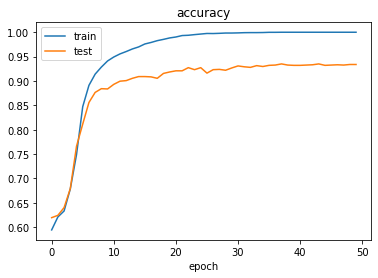

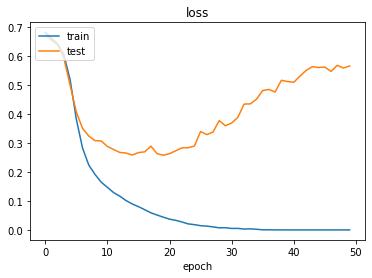

In [128]:
plot_accuracy(history)
plot_loss(history)

In [110]:
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

model = Sequential()
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 

model.add(Conv1D(100, 3, activation="relu"))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D())
model.add(Conv1D(100, 3, activation="relu"))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(64, activation='softmax'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 24, 300)           2744100   
                                                                 
 conv1d_65 (Conv1D)          (None, 22, 100)           90100     
                                                                 
 conv1d_66 (Conv1D)          (None, 20, 100)           30100     
                                                                 
 dropout_24 (Dropout)        (None, 20, 100)           0         
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 10, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_67 (Conv1D)          (None, 8, 100)            30100     
                                                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 - 2s - loss: 1.2326 - accuracy: 0.5376 - val_loss: 0.7302 - val_accuracy: 0.7943 - 2s/epoch - 44ms/step
Epoch 2/100
38/38 - 0s - loss: 0.3093 - accuracy: 0.8784 - val_loss: 0.2762 - val_accuracy: 0.9318 - 270ms/epoch - 7ms/step
Epoch 3/100
38/38 - 0s - loss: 0.0546 - accuracy: 0.9858 - val_loss: 0.1502 - val_accuracy: 0.9522 - 258ms/epoch - 7ms/step
Epoch 4/100
38/38 - 0s - loss: 0.0133 - accuracy: 0.9962 - val_loss: 0.1604 - val_accuracy: 0.9415 - 282ms/epoch - 7ms/step
Epoch 5/100
38/38 - 0s - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.1771 - val_accuracy: 0.9396 - 291ms/epoch - 8ms/step
Epoch 6/100
38/38 - 0s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1619 - val_accuracy: 0.9454 - 292ms/epoch - 8ms/step
Epoch 7/100
38/38 - 0s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.2217 - val_accuracy: 0.9327 - 265ms/epoch - 7ms/step
Epoch 8/100
38/38 - 0s - loss: 5.4005e-04 - accuracy: 1.0000 - val_loss: 0.1838 - val_accuracy: 0.9376 - 260ms/epoch - 7ms/step
Epoch 9/100
38/38 

KeyboardInterrupt: ignored

In [ ]:
# plot dos gráficos
plot_accuracy(history)
plot_loss(history)

In [ ]:
# lr_schedule = schedules.ExponentialDecay(
#     initial_learning_rate=lr,
#     decay_steps=10000,
#     decay_rate=0.9)

# https://keras.io/api/optimizers/
# https://keras.io/examples/nlp/pretrained_word_embeddings/
# https://keras.io/api/layers/base_layer/#layer-class

# optimizer = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta") 
#optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name="SGD")
#optimizer = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=True,name="RMSprop")
#optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
#optimizer = Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
#optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") # 96% Embedding Treinado /
#optimizer = Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.1, l2_regularization_strength=0.1, l2_shrinkage_regularization_strength=0.001, beta=0.0001, name="Ftrl")

# # defininindo a camada de embedding utilizando a matriz
# embedding_layer = Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
#                             output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
#                             # weights=[MATRIZ_CBOW_300_BASE_2],
#                             embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
#                             input_length=tam_max,
#                             trainable=False)


model = Sequential()
# primeira camada se trata do embedding. 
# model.add(embedding_layer)
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 


# camada convolucional
# filtros referentes ao output dessa camada,
# tamanho nucleo = 3, se tratando apenas de uma dimensão (conv1d)
# padding 'valid' = sem padding
# função de ativação = relu
model.add(Dropout(drp))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# camada convolucional                         'valid|same'
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# nivela o output para utilização na camada densa
model.add(Flatten())

# regularização por dropout
model.add(Dense(2, activation='softmax'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# plot dos gráficos
plot_accuracy(history)
plot_loss(history)

In [ ]:
tf.keras.utils.plot_model(model, to_file='/meuarquivo.png', show_shapes=True)